In [58]:
# %load .\base_code\base.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def resumetable(df):
    summary = pd.DataFrame(df.dtypes, columns=['type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피쳐'})
    summary['결측치'] = df.isnull().sum().values
    summary['고유값'] = df.nunique().values
    summary['임의값'] = df.loc[0].values

    return summary


def write_percent(fig, total_size):
    for patch in fig.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        fig.text(x=left_coord + width/2,
                 y=height + total_size*0.001,
                 s=f'{percent:1.1f}%',
                 ha='center'
                )
    return None


def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab


def plot_pointplot(ax, feature, crosstab, train):
    # sns.countplot(data=train, x=feature, order=crosstab[feature].values, ax=ax)
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab, order=crosstab[feature].values)
    ax2.set_ylabel('Target Ratio(%)')
    return None


def plot_ratio(df, features, num_rows, num_cols, x_size, size=(12,18), wspace=0.45, option='point'):
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows,num_cols)
    plt.subplots_adjust(wspace=wspace, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature)

        if x_size:
            df[feature] = pd.cut(df[feature], x_size)
        
        write_percent(ax, len(df))
        if option == 'point':
            sns.countplot(x=feature, data=df,
                     order=crosstab[feature].values,
                     color='skyblue',
                     ax=ax)
            plot_pointplot(ax, feature, crosstab, df)
        elif option == 'bar':
            sns.barplot(ax=ax, x=feature, y='target', data=df, palette='Set2')

        ax.set_title(f'{feature} Dis')
    
    return None

In [48]:
import warnings

warnings.filterwarnings(action='ignore') 

## 목차
- [1. 경진대회 이해](#1-경진대회-이해)
- [2. 탐색적 데이터 분석](#2-탐색적-데이터-분석)
  * [2.1. 데이터 둘러보기](#21-데이터-둘러보기)
  * [2.2. 데이터 시각화](#22-데이터-시각화)
- [3. 베이스라인 모델](#3-베이스라인-모델)
  * [3.1. 피쳐 엔지니어링](#31-피쳐-엔지니어링)
  * [3.2. 평가지표 계산 함수 작성](#32-평가지표-계산-함수-작성)
  * [3.3. 모델 훈련 및 성능 검증](#33-모델-훈련-및-성능-검증)
  * [3.4. 예측 및 결과 제출](#34-예측-및-결과-제출)
- [4. 성능 개선 1:LightGBM 모델](#4-성능-개선-1lightgbm-모델)
  * [4.1. 피쳐 엔지니어링](#41-피쳐-엔지니어링)
  * [4.2. 하이퍼파라미터 최적화](#42-하이퍼파라미터-최적화)
  * [4.3. 모델 훈련 및 성능 검증](#43-모델-훈련-및-성능-검증)
  * [4.4. 예측 및 결과 제출](#44-예측-및-결과-제출)
- [5. 성능 개선 2:XGBoost 모델](#5-성능-개선-2xgboost-모델)
  * [5.1. 피쳐 엔지니어링](#51-피쳐-엔지니어링)
  * [5.2. 하이퍼파라미터 최적화](#52-하이퍼파라미터-최적화)
  * [5.3. 모델 훈련 및 성능 검증](#53-모델-훈련-및-성능-검증)
  * [5.4. 예측 및 결과 제출](#54-예측-및-결과-제출)
- [6. 성능 개선 3:LightGBM과 XGBoost 앙상블](#6-성능-개선-3lightgbm과-xgboost-앙상블)
  * [6.1. 앙상블 수행](#61-앙상블-수행)
  * [6.2. 예측 및 결과 제출](#62-예측-및-결과-제출)
- [7. 학습 마무리](#7-학습-마무리)
  * [7.1. 핵심 요약](#71-핵심-요약)

<a name="1-경진대회-이해"></a>
# 1. 경진대회 이해

<a name="2-탐색적-데이터-분석"></a>
# 2. 탐색적 데이터 분석

<a name="21-데이터-둘러보기"></a>
## 2.1. 데이터 둘러보기

In [62]:
import pandas as pd
import numpy as np

data_path = './dataset/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [3]:
train.head(2)

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_bin 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892816 entries, 0 to 1488026
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ps_ind_01       892816 non-null  int64  
 1   ps_ind_02_cat   892816 non-null  int64  
 2   ps_ind_03       892816 non-null  int64  
 3   ps_ind_04_cat   892816 non-null  int64  
 4   ps_ind_05_cat   892816 non-null  int64  
 5   ps_ind_06_bin   892816 non-null  int64  
 6   ps_ind_07_bin   892816 non-null  int64  
 7   ps_ind_08_bin   892816 non-null  int64  
 8   ps_ind_09_bin   892816 non-null  int64  
 9   ps_ind_10_bin   892816 non-null  int64  
 10  ps_ind_11_bin   892816 non-null  int64  
 11  ps_ind_12_bin   892816 non-null  int64  
 12  ps_ind_13_bin   892816 non-null  int64  
 13  ps_ind_14       892816 non-null  int64  
 14  ps_ind_15       892816 non-null  int64  
 15  ps_ind_16_bin   892816 non-null  int64  
 16  ps_ind_17_bin   892816 non-null  int64  
 17  ps_ind_18_bin 

In [6]:
train_copy = train.copy().replace(-1,np.NaN)

In [7]:
train_bin_index = train.columns[train.columns.str.contains('bin')]

In [8]:
train_cat_index = train.columns[train.columns.str.contains('cat')]

In [63]:
train_etc_index = train.columns[~(train.columns.str.contains('cat') | train.columns.str.contains('bin') | train.columns.str.contains('target'))]

In [64]:
train_int_index = train_etc_index[train[train_etc_index].dtypes == 'int64']
train_float_index = train_etc_index[train[train_etc_index].dtypes == 'float64']

<a name="22-데이터-시각화"></a>
## 2.2. 데이터 시각화

In [41]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt

In [42]:
from base_code import base as base_code

d:\win\Projects\test2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\win\Projects\test2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\win\Projects\test2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Target Distribution')

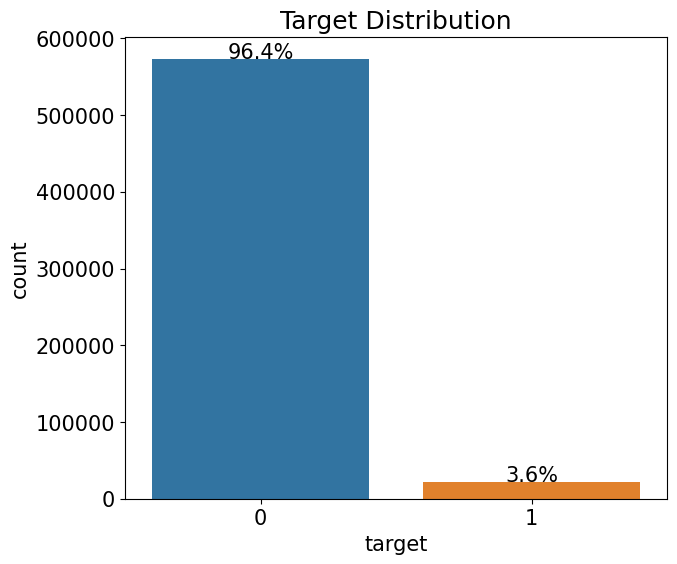

In [43]:
mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train)
base_code.write_percent(ax, len(train))
ax.set_title('Target Distribution')

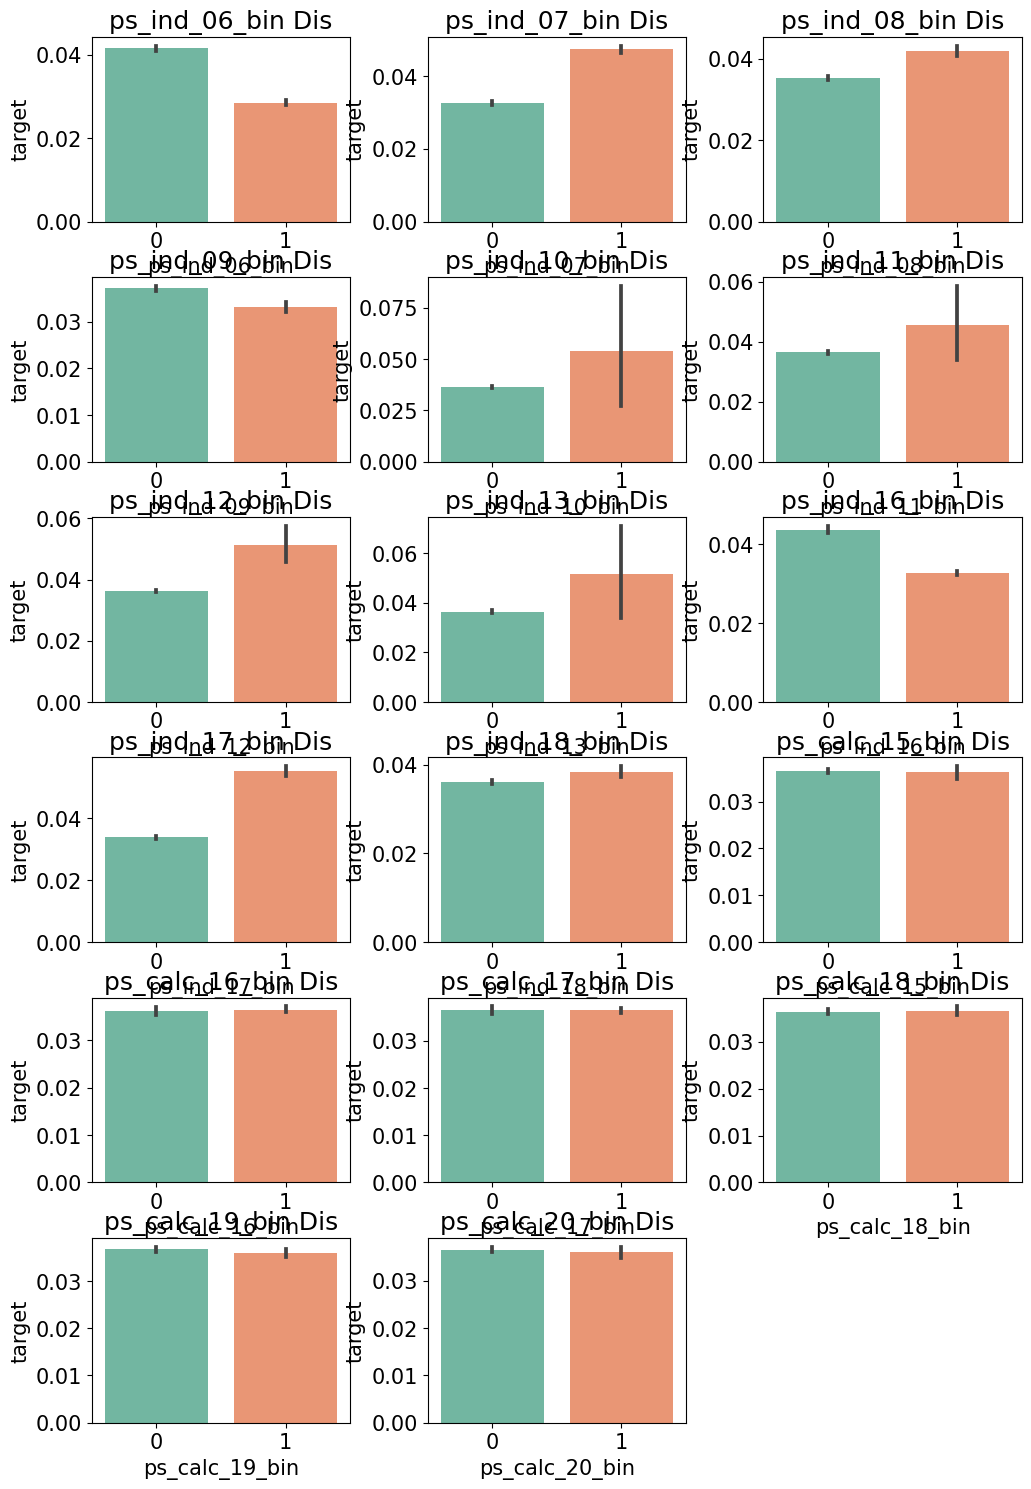

In [97]:
plot_ratio(train, train_bin_index, 6, 3, wspace=0.3, option='bar')

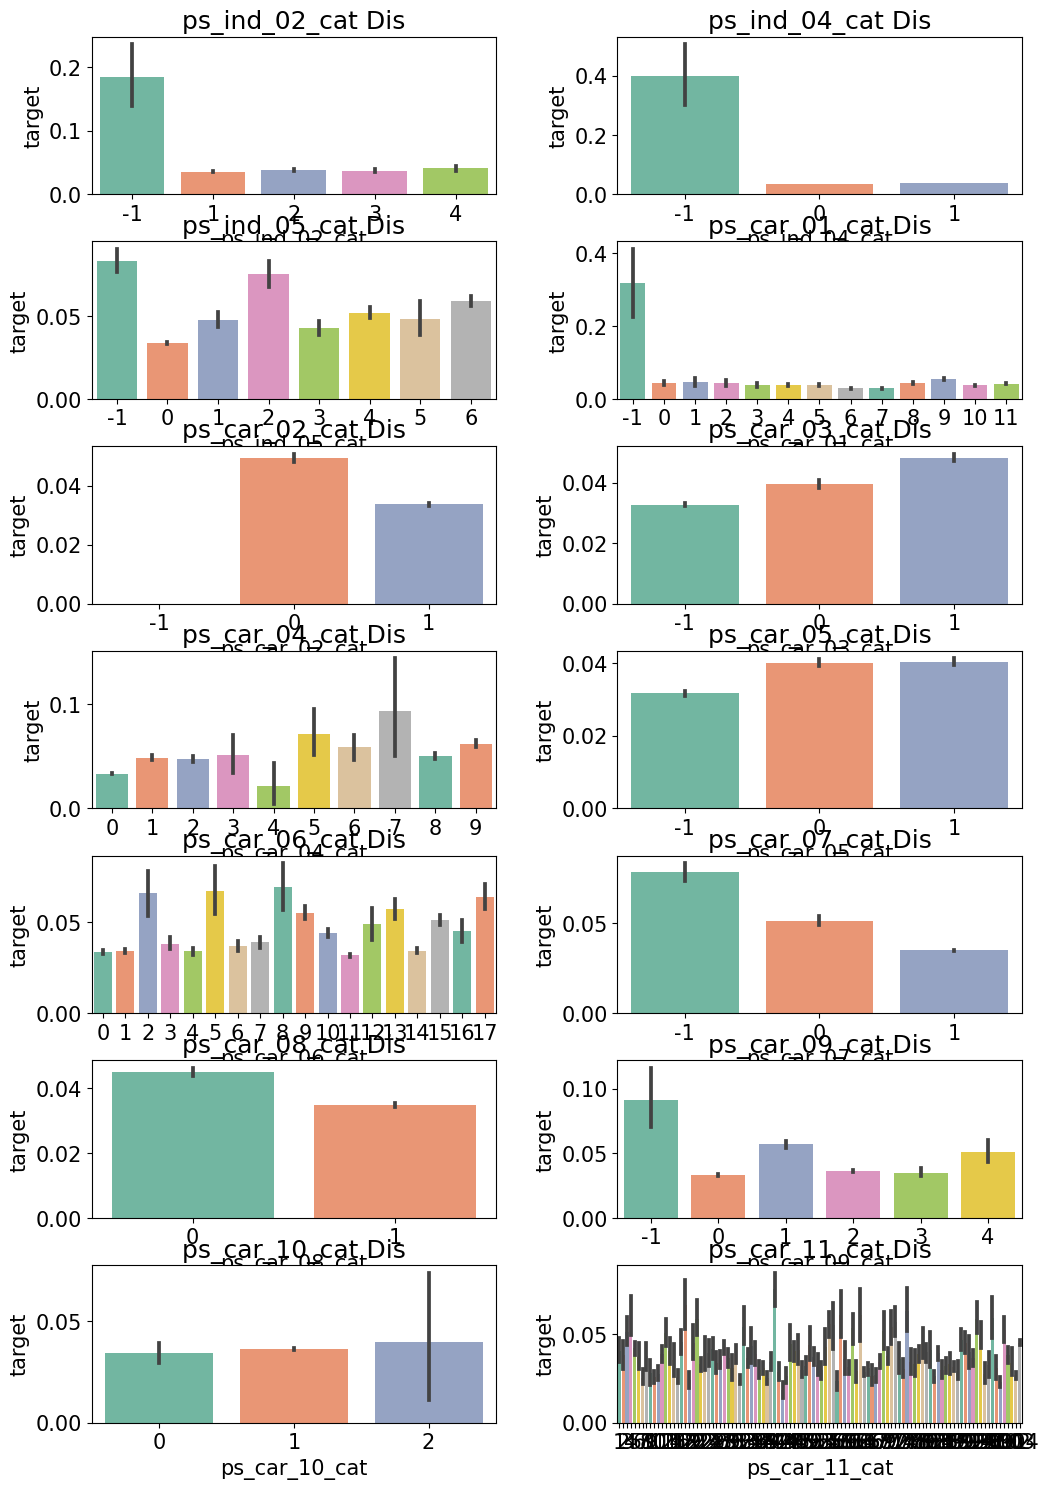

In [98]:
plot_ratio(train, train_cat_index, 7, 2, wspace=0.3, option='bar')

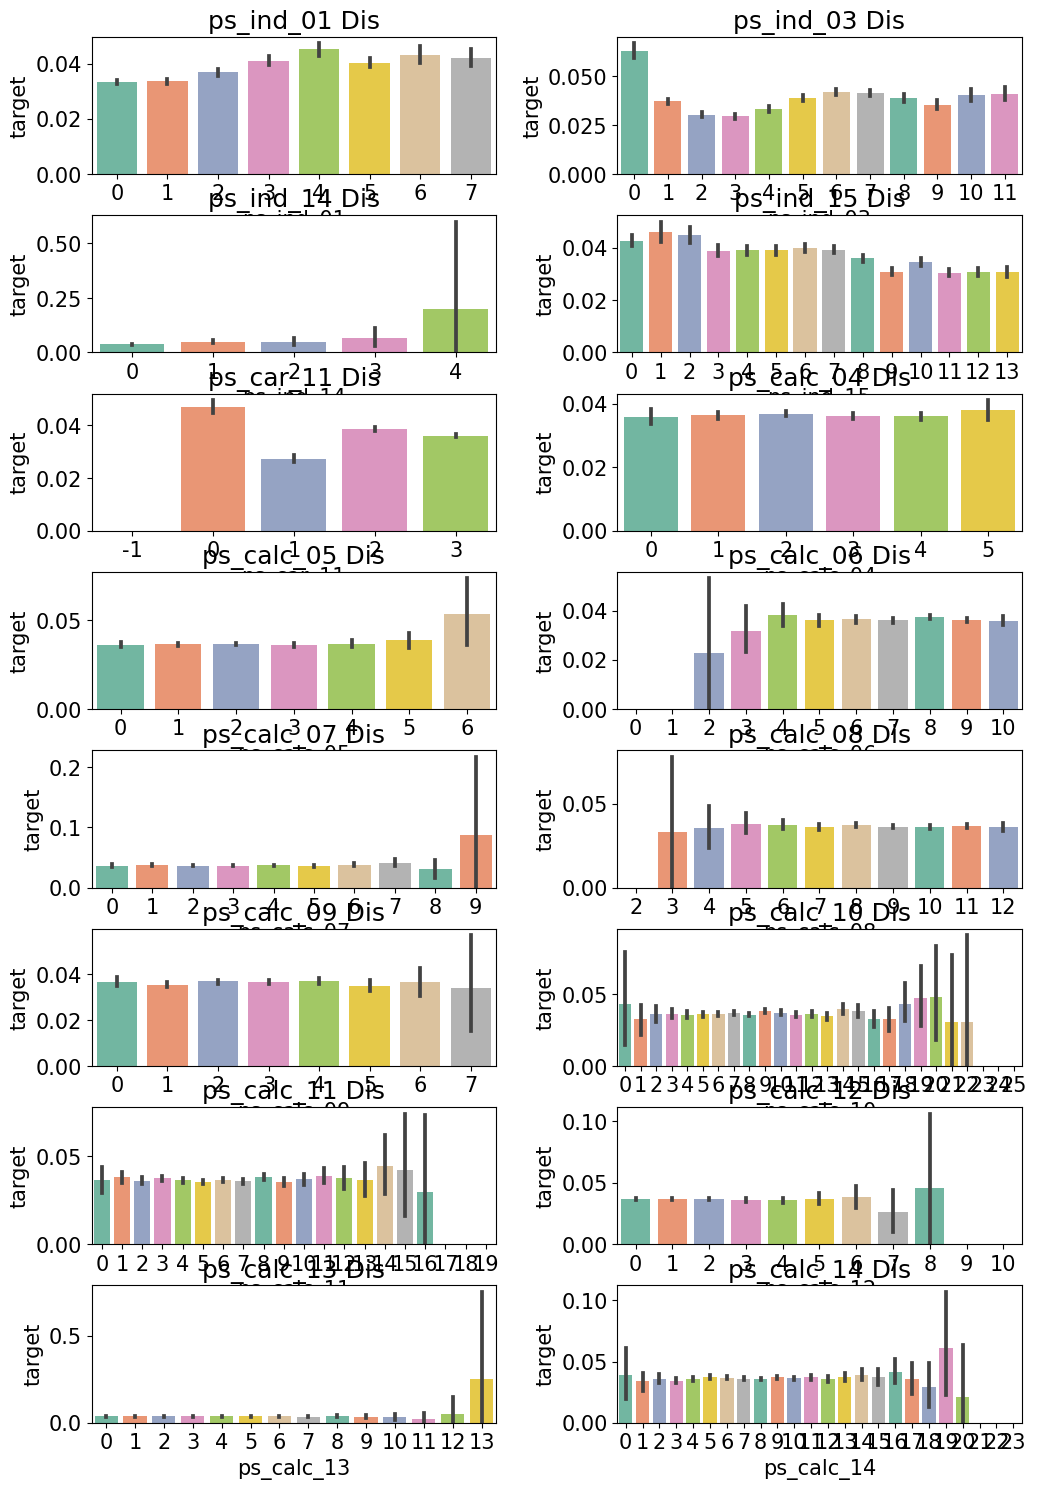

In [49]:
plot_ratio(train, train_int_index, 8, 2, wspace=0.3, option='bar')

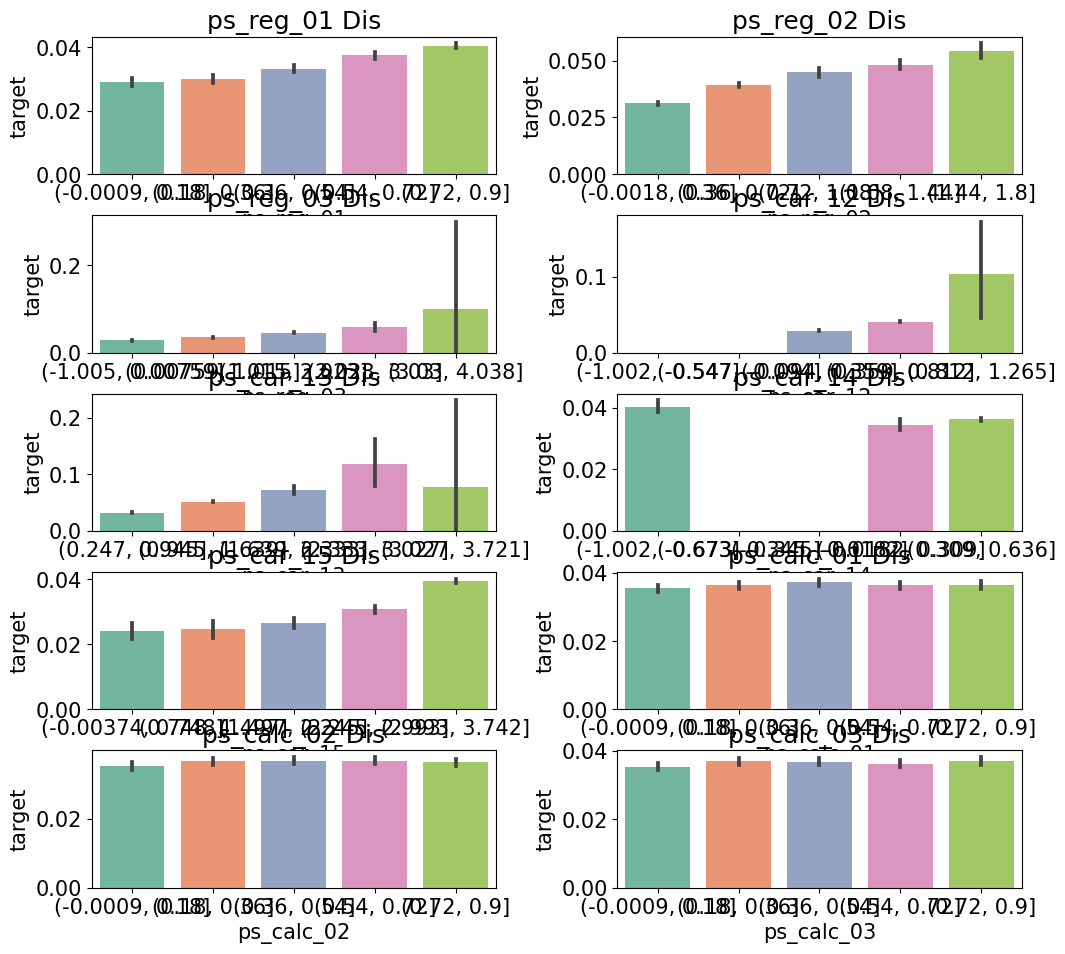

In [59]:
plot_ratio(train, train_float_index, 8, 2, wspace=0.3, option='bar', x_size=5)

<Axes: >

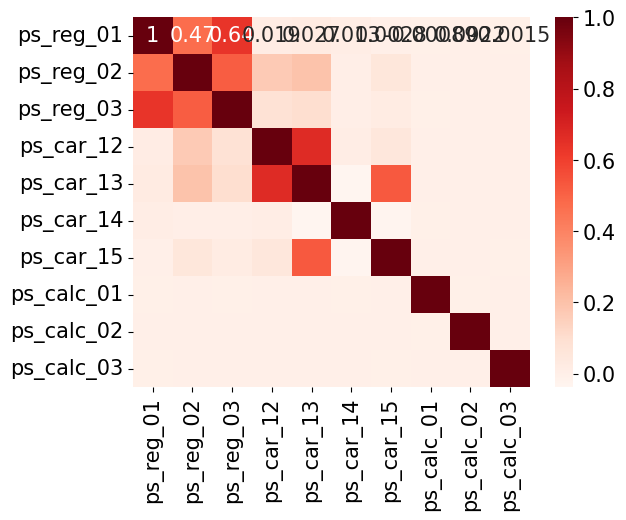

In [79]:
corr_value = train[train_float_index].dropna().corr()
sns.heatmap(corr_value, annot=True, cmap='Reds')

<a name="3-베이스라인-모델"></a>
# 3. 베이스라인 모델

<a name="31-피쳐-엔지니어링"></a>
## 3.1. 피쳐 엔지니어링

In [80]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)
all_data

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488023,0,1,6,0,0,0,1,0,0,0,...,4,2,3,4,0,1,0,0,1,0
1488024,5,3,5,1,0,0,0,1,0,0,...,6,2,2,11,0,0,1,1,0,0
1488025,0,1,5,0,0,1,0,0,0,0,...,5,2,2,11,0,1,1,0,0,0
1488026,6,1,5,1,0,0,0,0,1,0,...,1,1,2,7,1,1,0,0,0,0


In [111]:
all_feature = all_data.columns

In [81]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()

encoded_cat_matrix = OHE.fit_transform(all_data[train_cat_index])

In [83]:
encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [82]:
drop_feature = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

all_data = all_data.drop(columns=drop_feature)
all_data

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_15,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,11,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,3,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,12,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,8,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,9,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488023,0,1,6,0,0,0,1,0,0,2,...,4,2,3,4,0,1,0,0,1,0
1488024,5,3,5,1,0,0,0,1,0,11,...,6,2,2,11,0,0,1,1,0,0
1488025,0,1,5,0,0,1,0,0,0,5,...,5,2,2,11,0,1,1,0,0,0
1488026,6,1,5,1,0,0,0,0,1,13,...,1,1,2,7,1,1,0,0,0,0


In [84]:
from scipy import sparse

all_data_sparse = sparse.hstack([sparse.csr_matrix(all_data), encoded_cat_matrix], format='csr')
all_data_sparse

<1488028x235 sparse matrix of type '<class 'numpy.float64'>'
	with 75814410 stored elements in Compressed Sparse Row format>

In [85]:
X = all_data_sparse[:len(train)]
X_test = all_data_sparse[len(train):]

y = train['target'].values

<a name="32-평가지표-계산-함수-작성"></a>
## 3.2. 평가지표 계산 함수 작성

In [86]:
def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]
    L_mid = np.linspace(1/n_samples,1,n_samples)

    pred_order = y_true[y_pred.argsort()]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred)

    true_order = y_true[y_true.argsort()]
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)

    return G_pred / G_true

In [91]:
def gini_check(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

<a name="33-모델-훈련-및-성능-검증"></a>
## 3.3. 모델 훈련 및 성능 검증

In [87]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [88]:
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'force_row_wise': True,
    'random_state': 42
}

In [106]:
oof_val_preds = np.zeros(X.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

In [99]:
import lightgbm as lgb

In [107]:
# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정 
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성 
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋

    # LightGBM 모델 훈련 
    lgb_model = lgb.train(params=params,        # 훈련용 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=1000, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini_check,           # 검증용 평가지표
                          callbacks=[
                              lgb.early_stopping(100, verbose=True)
                          ])
                        #   early_stopping_rounds=100, # 조기종료 조건
                        #   verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    print(oof_test_preds, oof_test_preds.shape)
    print(lgb_model.predict(X_test), lgb_model.predict(X_test).shape)
    print(folds.n_splits)
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	valid_0's binary_logloss: 0.151641	valid_0's gini: 0.29015
[0. 0. 0. ... 0. 0. 0.] (892816,)
[0.0270991  0.02580766 0.0292813  ... 0.03794367 0.02428806 0.02798221] (892816,)
5
폴드 1 지니계수 : 0.29015029065985404

######################################## 폴드 2 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 

<a name="34-예측-및-결과-제출"></a>
## 3.4. 예측 및 결과 제출

<a name="4-성능-개선-1lightgbm-모델"></a>
# 4. 성능 개선 1:LightGBM 모델

<a name="41-피쳐-엔지니어링"></a>
## 4.1. 피쳐 엔지니어링

In [110]:
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [112]:
remaining_feature = [feature for feature in all_feature
                     if ('cat' not in feature and 'calc' not in feature)]

# remaining_feature.append('num_missing')

In [116]:

ind_features = [feature for feature in all_feature if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [121]:
cat_feature = [feature for feature in all_feature if 'cat' in feature] 
cat_count_features = []
for feature in cat_feature+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [123]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data[:num_train]
X_test = all_data[num_train:]

y = train['target'].values

<a name="42-하이퍼파라미터-최적화"></a>
## 4.2. 하이퍼파라미터 최적화

In [139]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)

# 베이지안 최적화용 데이터셋
bayes_dtrain = lgb.Dataset(X_train.drop(columns=['mix_ind']), y_train)
bayes_dvalid = lgb.Dataset(X_valid.drop(columns=['mix_ind']), y_valid)

In [125]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves': (30, 40),
                'lambda_l1': (0.7, 0.9),
                'lambda_l2': (0.9, 1),
                'feature_fraction': (0.6, 0.7),
                'bagging_fraction': (0.6, 0.9),
                'min_child_samples': (6, 10),
                'min_child_weight': (10, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary',
                'learning_rate': 0.005,
                'bagging_freq': 1,
                'force_row_wise': True,
                'random_state': 42}

In [144]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'num_leaves': int(round(num_leaves)),
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'feature_fraction': feature_fraction,
              'bagging_fraction': bagging_fraction,
              'min_child_samples': int(round(min_child_samples)),
              'min_child_weight': min_child_weight,
              'feature_pre_filter': False}
    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, 
                           train_set=bayes_dtrain,
                           num_boost_round=2500,
                           valid_sets=bayes_dvalid,
                           feval=gini_check,
                          callbacks=[
                              lgb.early_stopping(100, verbose=True)
                          ])
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid.drop(columns=['mix_ind'])) 
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [145]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수
                                 pbounds=param_bounds, # 하이퍼파라미터 범위
                                 random_state=42)

In [146]:
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 31, 'lambda_l1': 0.846398788362281, 'lambda_l2': 0.9598658484197037, 'feature_fraction': 0.6950714306409915, 'bagging_fraction': 0.7123620356542087, 'min_child_samples': 7, 'min_child_weight': 14.67983561008608, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 42}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
Training until validation scores don't improve for 100 rounds
Early sto

In [147]:
max_params = optimizer.max['params']
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [148]:
max_params.update(fixed_params)

In [149]:
max_params

{'bagging_fraction': 0.8995668904913383,
 'feature_fraction': 0.6051165519779909,
 'lambda_l1': 0.8565129858064342,
 'lambda_l2': 0.9742324550282261,
 'min_child_samples': 9,
 'min_child_weight': 20.478431640827402,
 'num_leaves': 35,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 42}

<a name="43-모델-훈련-및-성능-검증"></a>
## 4.3. 모델 훈련 및 성능 검증

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params,    # 최적 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=2500, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini_check,           # 검증용 평가지표
                          early_stopping_rounds=300, # 조기종료 조건
                          verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

In [ ]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

<a name="44-예측-및-결과-제출"></a>
## 4.4. 예측 및 결과 제출

<a name="5-성능-개선-2xgboost-모델"></a>
# 5. 성능 개선 2:XGBoost 모델

In [163]:
import pandas as pd

# 데이터 경로
data_path = './dataset/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

<a name="51-피쳐-엔지니어링"></a>
## 5.1. 피쳐 엔지니어링

In [164]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

In [165]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature]

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

In [166]:
# '데이터 하나당 결측값 개수'를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [167]:
# 명목형 피처, calc 분류 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [168]:
# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [169]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [170]:
from scipy import sparse

# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

In [171]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [172]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [173]:
# XGBoost용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

<a name="52-하이퍼파라미터-최적화"></a>
## 5.2. 하이퍼파라미터 최적화

In [174]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)
# 베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

In [175]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'max_depth': (4, 8),
                'subsample': (0.6, 0.9),
                'colsample_bytree': (0.7, 1.0),
                'min_child_weight': (5, 7),
                'gamma': (8, 11),
                'reg_alpha': (7, 9),
                'reg_lambda': (1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary:logistic',
                'learning_rate': 0.02,
                'random_state': 1991}

In [181]:
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                 reg_alpha, gamma, reg_lambda, scale_pos_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'max_depth': int(round(max_depth)),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'reg_alpha':reg_alpha,
              'reg_lambda': reg_lambda,
              'scale_pos_weight': scale_pos_weight}
    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터 :', params)    
        
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2000,
                          evals=[(bayes_dvalid, 'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=False)
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수
    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, 
                              iteration_range=(0, best_iter))
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [182]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function, 
                                 pbounds=param_bounds, 
                                 random_state=0)

# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 : {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}
지니계수 : 0.006971138089076641

| 1         | 0.006971  | 0.8646    | 10.15     | 6.411     | 6.09      | 7.847     | 1.358     | 1.488     | 0.8675    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6261387899104622, 'colsample_bytree': 0.9890988281503088, 'min_child_weight': 6.0577898395058085, 'gamma': 9.150324556477333, 'reg_alpha': 8.136089122187865, 'reg_lambda': 1.4702386553170643, 'scale_pos_weight': 1.

In [184]:
max_params = optimizer.max['params']

In [186]:
max_params['max_depth'] = int(round(max_params['max_depth']))

# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)
max_params

{'colsample_bytree': 0.9890988281503088,
 'gamma': 9.150324556477333,
 'max_depth': 7,
 'min_child_weight': 6.0577898395058085,
 'reg_alpha': 8.136089122187865,
 'reg_lambda': 1.4702386553170643,
 'scale_pos_weight': 1.4142072116395774,
 'subsample': 0.6261387899104622,
 'objective': 'binary:logistic',
 'learning_rate': 0.02,
 'random_state': 1991}

<a name="53-모델-훈련-및-성능-검증"></a>
## 5.3. 모델 훈련 및 성능 검증

In [187]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += xgb_model.predict(dtest,
                                        iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid, 
                                                  iteration_range=(0, best_iter))
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[0]	valid-logloss:0.21730	valid-gini:0.19475
[100]	valid-logloss:0.15994	valid-gini:0.27304
[200]	valid-logloss:0.15477	valid-gini:0.28614
[300]	valid-logloss:0.15407	valid-gini:0.29087
[400]	valid-logloss:0.15394	valid-gini:0.29218
[500]	valid-logloss:0.15391	valid-gini:0.29261
[600]	valid-logloss:0.15389	valid-gini:0.29289
[700]	valid-logloss:0.15388	valid-gini:0.29324
[800]	valid-logloss:0.15387	valid-gini:0.29342
[900]	valid-logloss:0.15389	valid-gini:0.29367
[1000]	valid-logloss:0.15386	valid-gini:0.29385
[1100]	valid-logloss:0.15385	valid-gini:0.29408
[1200]	valid-logloss:0.15386	valid-gini:0.29410
[1300]	valid-logloss:0.15386	valid-gini:0.29415
[1400]	valid-logloss:0.15384	valid-gini:0.29424
[1500]	valid-logloss:0.15384	valid-gini:0.29426
[1600]	valid-logloss:0.15383	valid-gini:0.29438
[1700]	valid-logloss:0.15385	valid-gini:0.29444
[1800]	valid-logloss:0.15383	valid-gini:0.29457
[1900]

<a name="54-예측-및-결과-제출"></a>
## 5.4. 예측 및 결과 제출

<a name="6-성능-개선-3lightgbm과-xgboost-앙상블"></a>
# 6. 성능 개선 3:LightGBM과 XGBoost 앙상블

<a name="61-앙상블-수행"></a>
## 6.1. 앙상블 수행

In [188]:
# LightGBM용 gini() 함수
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

In [189]:
# XGBoost용 gini() 함수
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

In [190]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [191]:
max_params_lgb = {
    'bagging_fraction': 0.6213108174593661,
    'feature_fraction': 0.608712929970154,
    'lambda_l1': 0.7040436794880651,
    'lambda_l2': 0.9832619845547939,
    'min_child_samples': 9,
    'min_child_weight': 36.10036444740457,
    'num_leaves': 40,
    'objective': 'binary',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'force_row_wise': True,
    'random_state': 1991
}

In [193]:
import lightgbm as lgb

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds_lgb = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_lgb = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params_lgb,     # 최적 하이퍼파라미터
                          train_set=dtrain,          # 훈련 데이터셋
                          num_boost_round=2500,      # 부스팅 반복 횟수
                          valid_sets=dvalid,         # 성능 평가용 검증 데이터셋
                          feval=gini_lgb,
                          callbacks=[
                              lgb.early_stopping(100, verbose=True)
                          ])
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds_lgb += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2164]	valid_0's binary_logloss: 0.151359	valid_0's gini: 0.298578
폴드 1 지니계수 : 0.29857768160144854

######################################## 폴드 2 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764

In [194]:
import xgboost as xgb

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds_xgb = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_xgb = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)

    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          feval=gini_xgb,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration

    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds_xgb += xgb_model.predict(dtest,
                                            iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, 
                                                      iteration_range=(0, best_iter))
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[0]	valid-logloss:0.21730	valid-gini:0.19475
[100]	valid-logloss:0.15994	valid-gini:0.27304
[200]	valid-logloss:0.15477	valid-gini:0.28614
[300]	valid-logloss:0.15407	valid-gini:0.29087
[400]	valid-logloss:0.15394	valid-gini:0.29218
[500]	valid-logloss:0.15391	valid-gini:0.29261
[600]	valid-logloss:0.15389	valid-gini:0.29289
[700]	valid-logloss:0.15388	valid-gini:0.29324
[800]	valid-logloss:0.15387	valid-gini:0.29342
[900]	valid-logloss:0.15389	valid-gini:0.29367
[1000]	valid-logloss:0.15386	valid-gini:0.29385
[1100]	valid-logloss:0.15385	valid-gini:0.29408
[1200]	valid-logloss:0.15386	valid-gini:0.29410
[1300]	valid-logloss:0.15386	valid-gini:0.29415
[1400]	valid-logloss:0.15384	valid-gini:0.29424
[1500]	valid-logloss:0.15384	valid-gini:0.29426
[1600]	valid-logloss:0.15383	valid-gini:0.29438
[1700]	valid-logloss:0.15385	valid-gini:0.29444
[1800]	valid-logloss:0.15383	valid-gini:0.29457
[1900]

In [195]:
print('LightGBM OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds_lgb))

LightGBM OOF 검증 데이터 지니계수 : 0.2888232784962285


In [196]:
print('XGBoost OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds_xgb))

XGBoost OOF 검증 데이터 지니계수 : 0.2841442077452205


In [ ]:
oof_test_preds = oof_test_preds_lgb * 0.5 + oof_test_preds_xgb * 0.5

<a name="62-예측-및-결과-제출"></a>
## 6.2. 예측 및 결과 제출

<a name="7-학습-마무리"></a>
# 7. 학습 마무리

<a name="71-핵심-요약"></a>
## 7.1. 핵심 요약